# Purpose

Vector 2022 skin was deployed on enwiki on 2023-01-18. Following analysis is to understand the impact on
- Usage of fixed width toggle

https://phabricator.wikimedia.org/T327440

QA ticket: https://phabricator.wikimedia.org/T322772

### New Feature  
Enabled with skin version vector 2022  
__At the right corner of the page__  

<img src="Figures/new1.png" width="800" height="600" align="center"/>   


If click on the button, event.name='limited-width-toggle-off' is created, resulting in the non-default behaviour e.g. content width is wider. (See below picture)
__After enable fixed width__   
<img src="Figures/new2.png" width="800" height="600" align="center"/>

If click on the button again, event.name='limited-width-toggle-on' is created, resulting the default behaviour e.g. content width is limited. (See picture 1)

In [3]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [4]:
options(repr.plot.width = 15, repr.plot.height = 10)

In [11]:
query_toggles <- "
-- temporary table for toggles
WITH t_c AS (
SELECT TO_DATE(meta.dt) AS event_date,   event.isAnon,
COUNT(DISTINCT event.token) AS toggled_sessions,
--HiveSQL count( ) counts all rows which are not null
COUNT(DISTINCT IF(event.name='limited-width-toggle-on', event.token,NULL)) AS toggle_on_sessions,
COUNT(DISTINCT IF(event.name='limited-width-toggle-off', event.token,NULL)) AS toggle_off_sessions,
SUM(IF(event.name='limited-width-toggle-on', 1,0)) AS toggle_ons,
SUM(IF(event.name='limited-width-toggle-off', 1,0)) AS toggle_offs,
COUNT(1) AS toatl_toggles
FROM event.desktopwebuiactionstracking
WHERE year=2023
AND wiki='enwiki'
AND event.action='click'
AND event.name IN ('limited-width-toggle-on', 'limited-width-toggle-off')
-- only vector-2022 has toggle button
AND event.skin='vector-2022'
GROUP BY TO_DATE(meta.dt),  event.isAnon
),
-- temporary table for initialization event
t_i AS (
SELECT TO_DATE(meta.dt) AS event_date,   event.isAnon, 
COUNT(DISTINCT event.token) AS init_sessions,
COUNT(1) AS inits
FROM event.desktopwebuiactionstracking
WHERE year=2023
AND event.action='init'
AND wiki='enwiki'
-- only vector-2022 has toggle button
AND event.skin='vector-2022'
GROUP BY TO_DATE(meta.dt),  event.isAnon
)

SELECT t_i.event_date, t_i.isAnon, t_i.init_sessions,t_c.toggled_sessions, 
t_c.toggle_on_sessions, t_c.toggle_off_sessions, inits, toggle_ons,toggle_offs
FROM t_i
LEFT OUTER JOIN t_c ON t_i.event_date=t_c.event_date AND t_i.isAnon=t_c.isAnon 
ORDER BY t_i.event_date, t_i.isAnon
LIMIT 100000
"

In [12]:
df_toggles <- wmfdata::query_hive(query_toggles)

Don't forget to authenticate with Kerberos using kinit



In [16]:
df_toggles <- df_toggles %>%
 mutate(
 session_toggle_rate=round(toggled_sessions/init_sessions, 6),
 toggle_on_rate=round(toggle_ons/inits,6)
 
 )

In [19]:
df_toggles$event_date <- as.Date(df_toggles$event_date)

In [20]:
df_toggles

event_date,isanon,init_sessions,toggled_sessions,toggle_on_sessions,toggle_off_sessions,inits,toggle_ons,toggle_offs,session_toggle_rate,toggle_on_rate
<date>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
2023-01-01,false,6611,11,11,10,119690,41,38,0.001664,0.000343
2023-01-02,false,7466,8,6,6,122428,6,10,0.001072,0.000049
2023-01-03,false,7938,9,8,9,134138,15,17,0.001134,0.000112
2023-01-04,false,7918,10,8,9,131109,15,15,0.001263,0.000114
2023-01-05,false,7924,10,9,10,129813,17,15,0.001262,0.000131
2023-01-06,false,7618,7,7,6,130377,11,9,0.000919,0.000084
2023-01-07,false,7175,9,9,8,127676,16,14,0.001254,0.000125
2023-01-08,false,7263,4,4,3,132040,6,4,0.000551,0.000045
2023-01-09,false,8168,9,9,8,132706,15,11,0.001102,0.000113


In [43]:
 df_toggles %>%
   # exclude the recent incompleted day
    slice(1:(n() - 2)) %>%
    filter(isanon=='false')

event_date,isanon,init_sessions,toggled_sessions,toggle_on_sessions,toggle_off_sessions,inits,toggle_ons,toggle_offs,session_toggle_rate,toggle_on_rate
<date>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
2023-01-01,false,6611,11,11,10,119690,41,38,0.001664,0.000343
2023-01-02,false,7466,8,6,6,122428,6,10,0.001072,0.000049
2023-01-03,false,7938,9,8,9,134138,15,17,0.001134,0.000112
2023-01-04,false,7918,10,8,9,131109,15,15,0.001263,0.000114
2023-01-05,false,7924,10,9,10,129813,17,15,0.001262,0.000131
2023-01-06,false,7618,7,7,6,130377,11,9,0.000919,0.000084
2023-01-07,false,7175,9,9,8,127676,16,14,0.001254,0.000125
2023-01-08,false,7263,4,4,3,132040,6,4,0.000551,0.000045
2023-01-09,false,8168,9,9,8,132706,15,11,0.001102,0.000113


In [44]:
 df_toggles %>%
   # exclude the recent incompleted day
    slice(1:(n() - 2)) %>%
    filter(isanon=='true')

event_date,isanon,init_sessions,toggled_sessions,toggle_on_sessions,toggle_off_sessions,inits,toggle_ons,toggle_offs,session_toggle_rate,toggle_on_rate
<date>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
2023-01-18,true,39516,45,45,6,41490,52,7,0.001139,0.001253
2023-01-19,true,272349,240,239,48,294328,316,83,0.000881,0.001074
2023-01-20,true,432543,288,288,42,473802,348,57,0.000666,0.000734


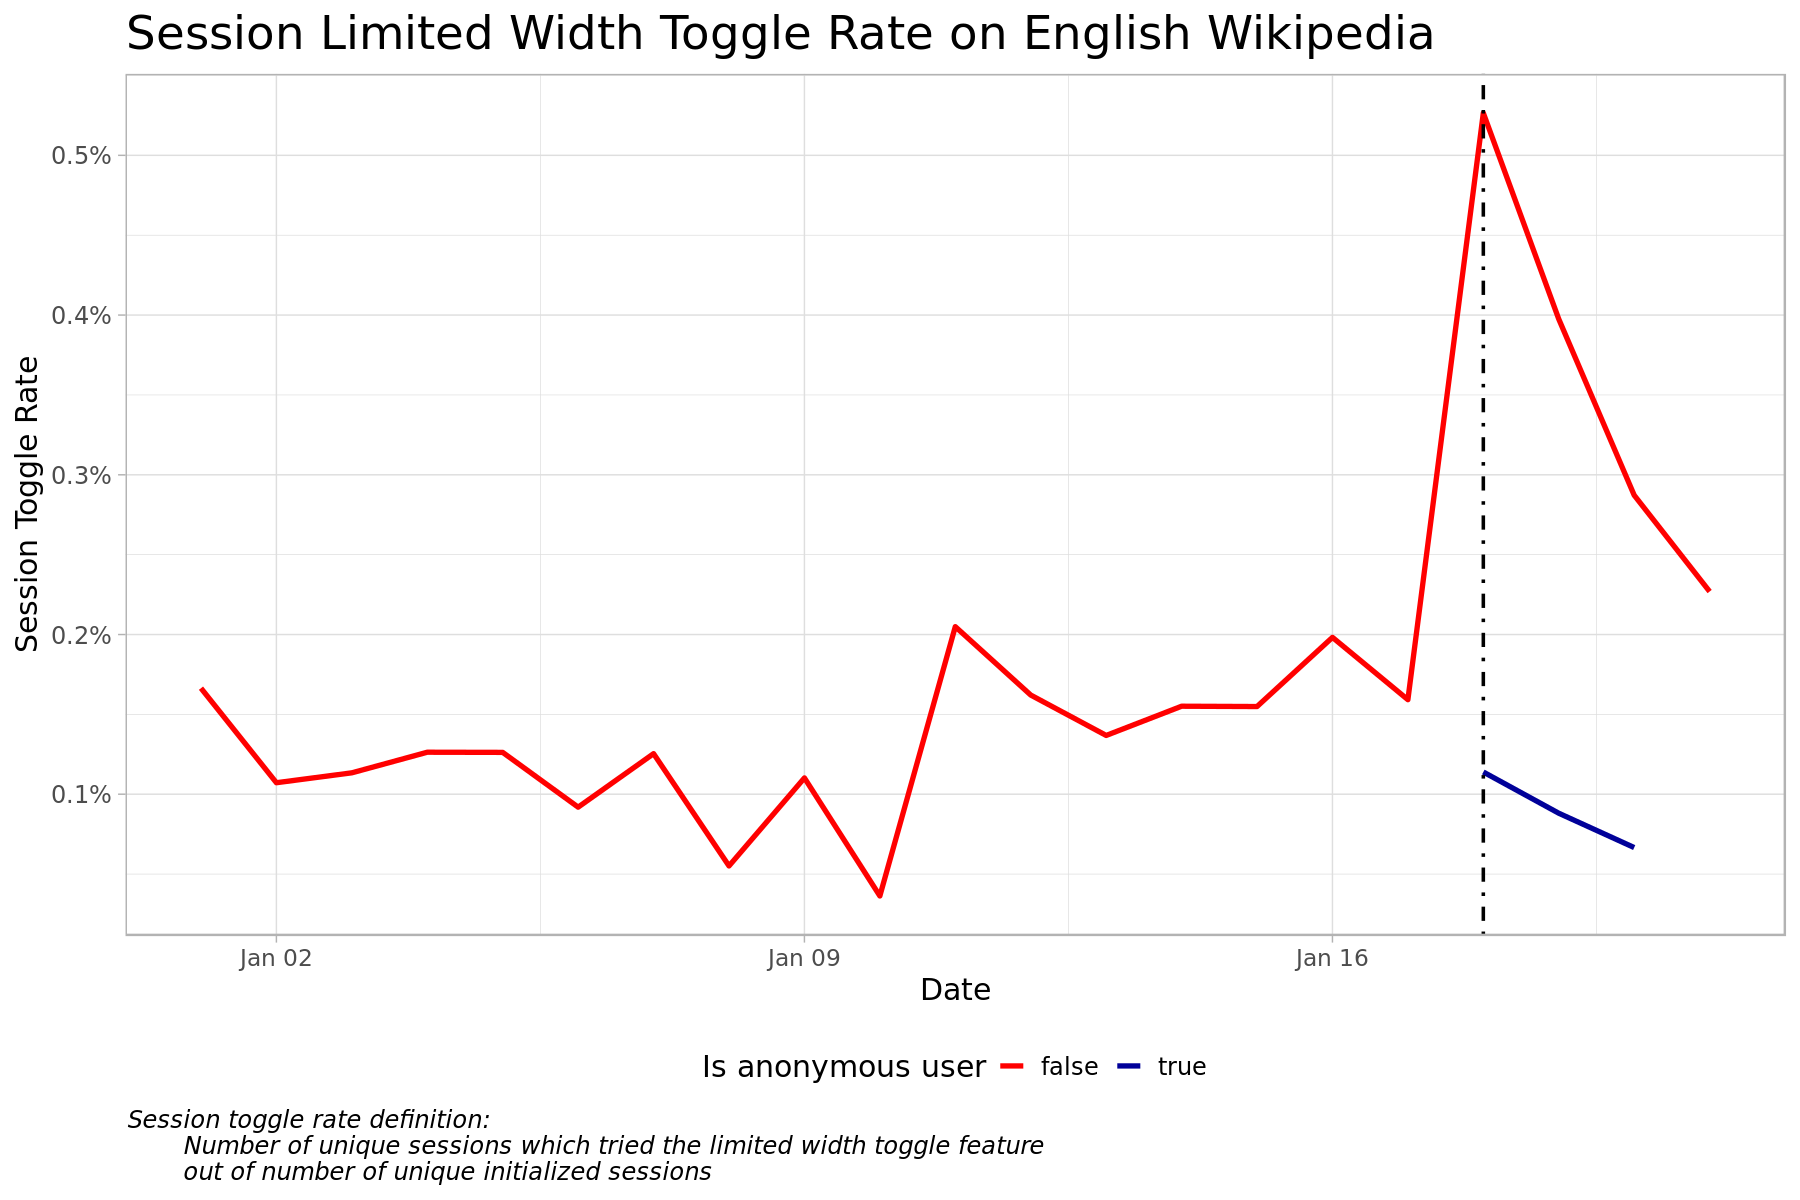

In [25]:
session_toggle_rate_g <- df_toggles %>%
   # exclude the recent incompleted day
    slice(1:(n() - 1)) %>%
   ggplot(mapping=aes(x=event_date, y=session_toggle_rate, color=isanon )) +
   geom_line( size = 1.5) +
   geom_vline(aes(xintercept = as.numeric(as.Date('2023-01-18'))), linetype="dotdash", color="black", size=1)+
   scale_color_manual(values= c("#FF0000", "#000099"), name = "Is anonymous user")  +
   scale_y_continuous(labels = scales::percent) +
  labs(title = 'Session Limited Width Toggle Rate on English Wikipedia',
     x = 'Date',
     y = 'Session Toggle Rate',
     caption = "Session toggle rate definition: 
       Number of unique sessions which tried the limited width toggle feature
       out of number of unique initialized sessions ") +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
session_toggle_rate_g

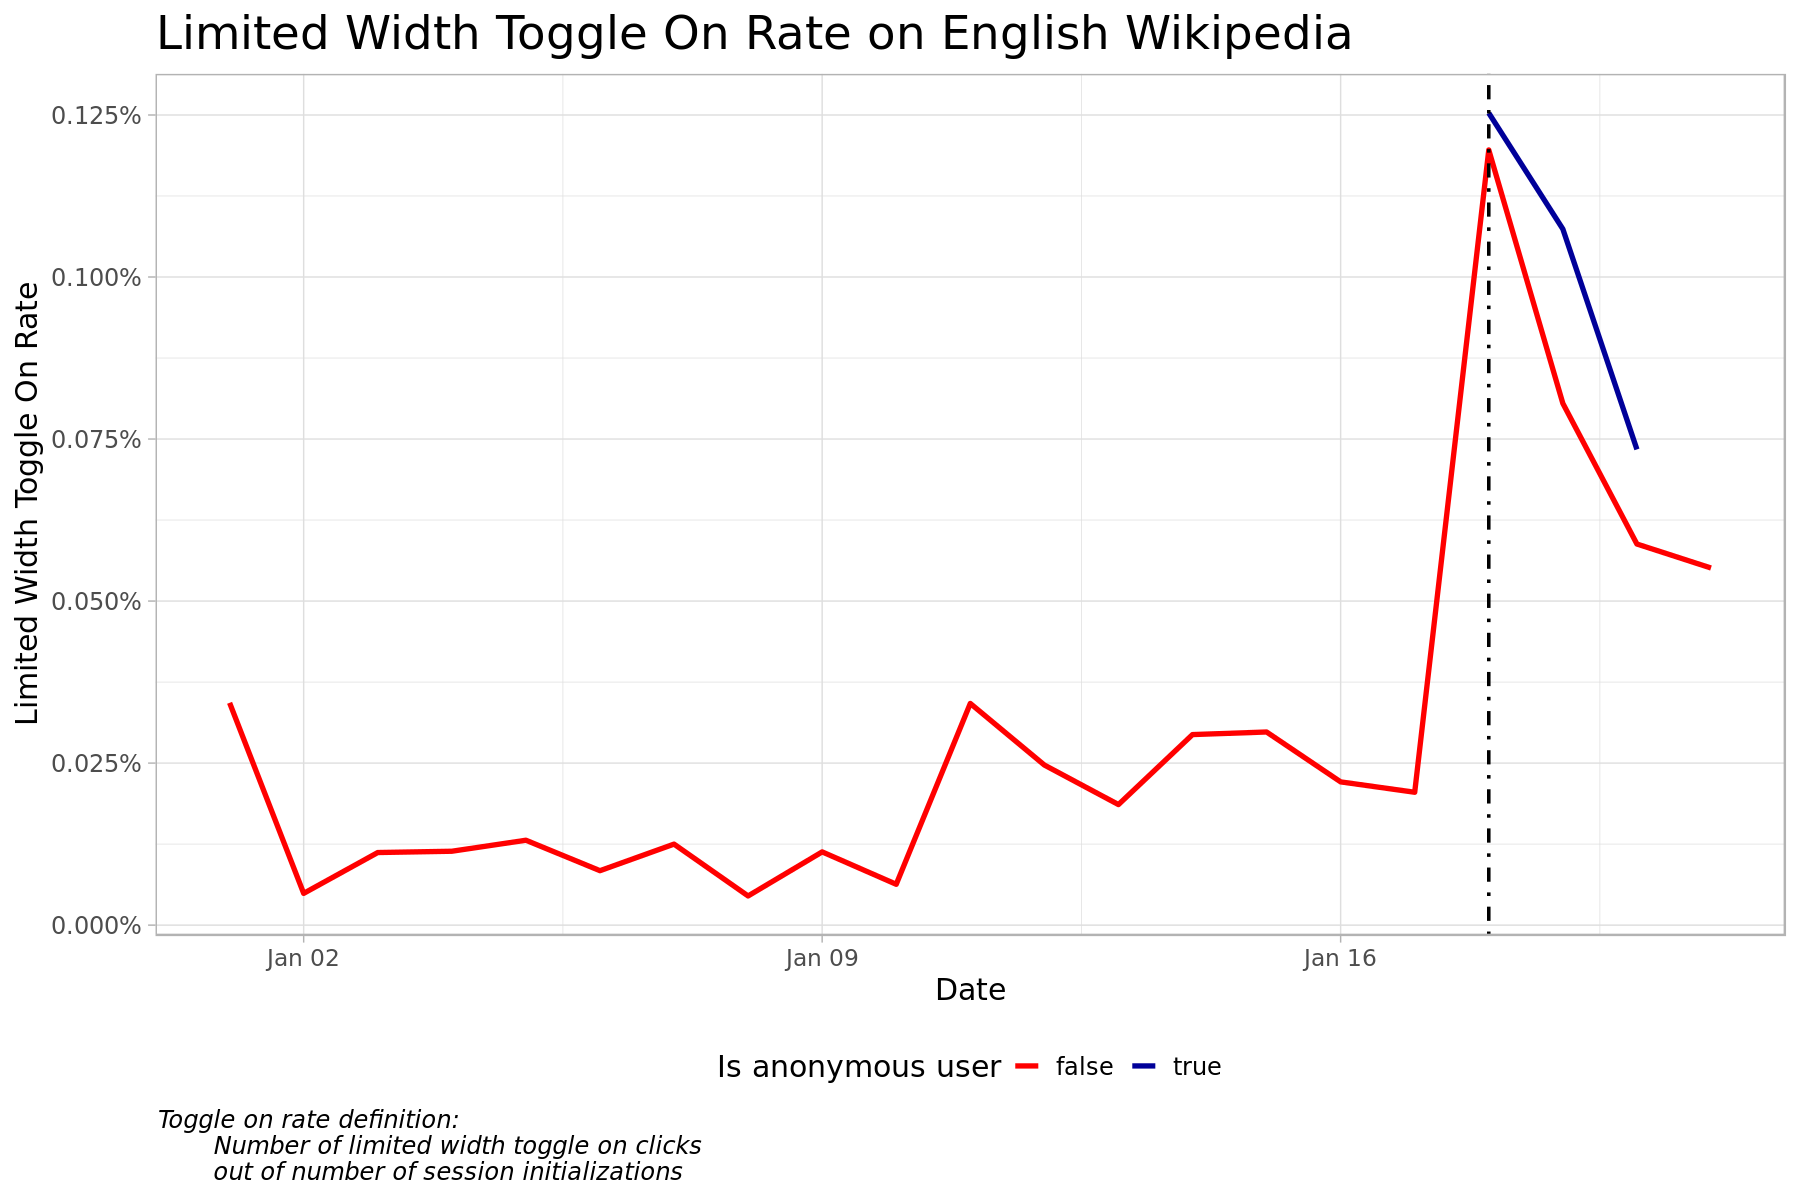

In [28]:
toggle_on_rate_g <- df_toggles %>%
   # exclude the recent incompleted day
    slice(1:(n() - 1)) %>%
   ggplot(mapping=aes(x=event_date, y=toggle_on_rate, color=isanon )) +
   geom_line( size = 1.5) +
   geom_vline(aes(xintercept = as.numeric(as.Date('2023-01-18'))), linetype="dotdash", color="black", size=1)+
   scale_color_manual(values= c("#FF0000", "#000099"), name = "Is anonymous user")  +
   scale_y_continuous(labels = scales::percent) +
  labs(title = 'Limited Width Toggle On Rate on English Wikipedia',
     x = 'Date',
     y = 'Limited Width Toggle On Rate',
     caption = "Toggle on rate definition: 
       Number of limited width toggle on clicks 
       out of number of session initializations ") +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
toggle_on_rate_g 

In [32]:
df_on_vs_off <- df_toggles %>%
 select(event_date, isanon, toggle_ons, toggle_offs) %>%
 pivot_longer(cols=c('toggle_ons','toggle_offs'), names_to="types", values_to="events")

In [33]:
df_on_vs_off 

event_date,isanon,types,events
<date>,<chr>,<chr>,<int>
2023-01-01,false,toggle_ons,41
2023-01-01,false,toggle_offs,38
2023-01-02,false,toggle_ons,6
2023-01-02,false,toggle_offs,10
2023-01-03,false,toggle_ons,15
2023-01-03,false,toggle_offs,17
2023-01-04,false,toggle_ons,15
2023-01-04,false,toggle_offs,15
2023-01-05,false,toggle_ons,17


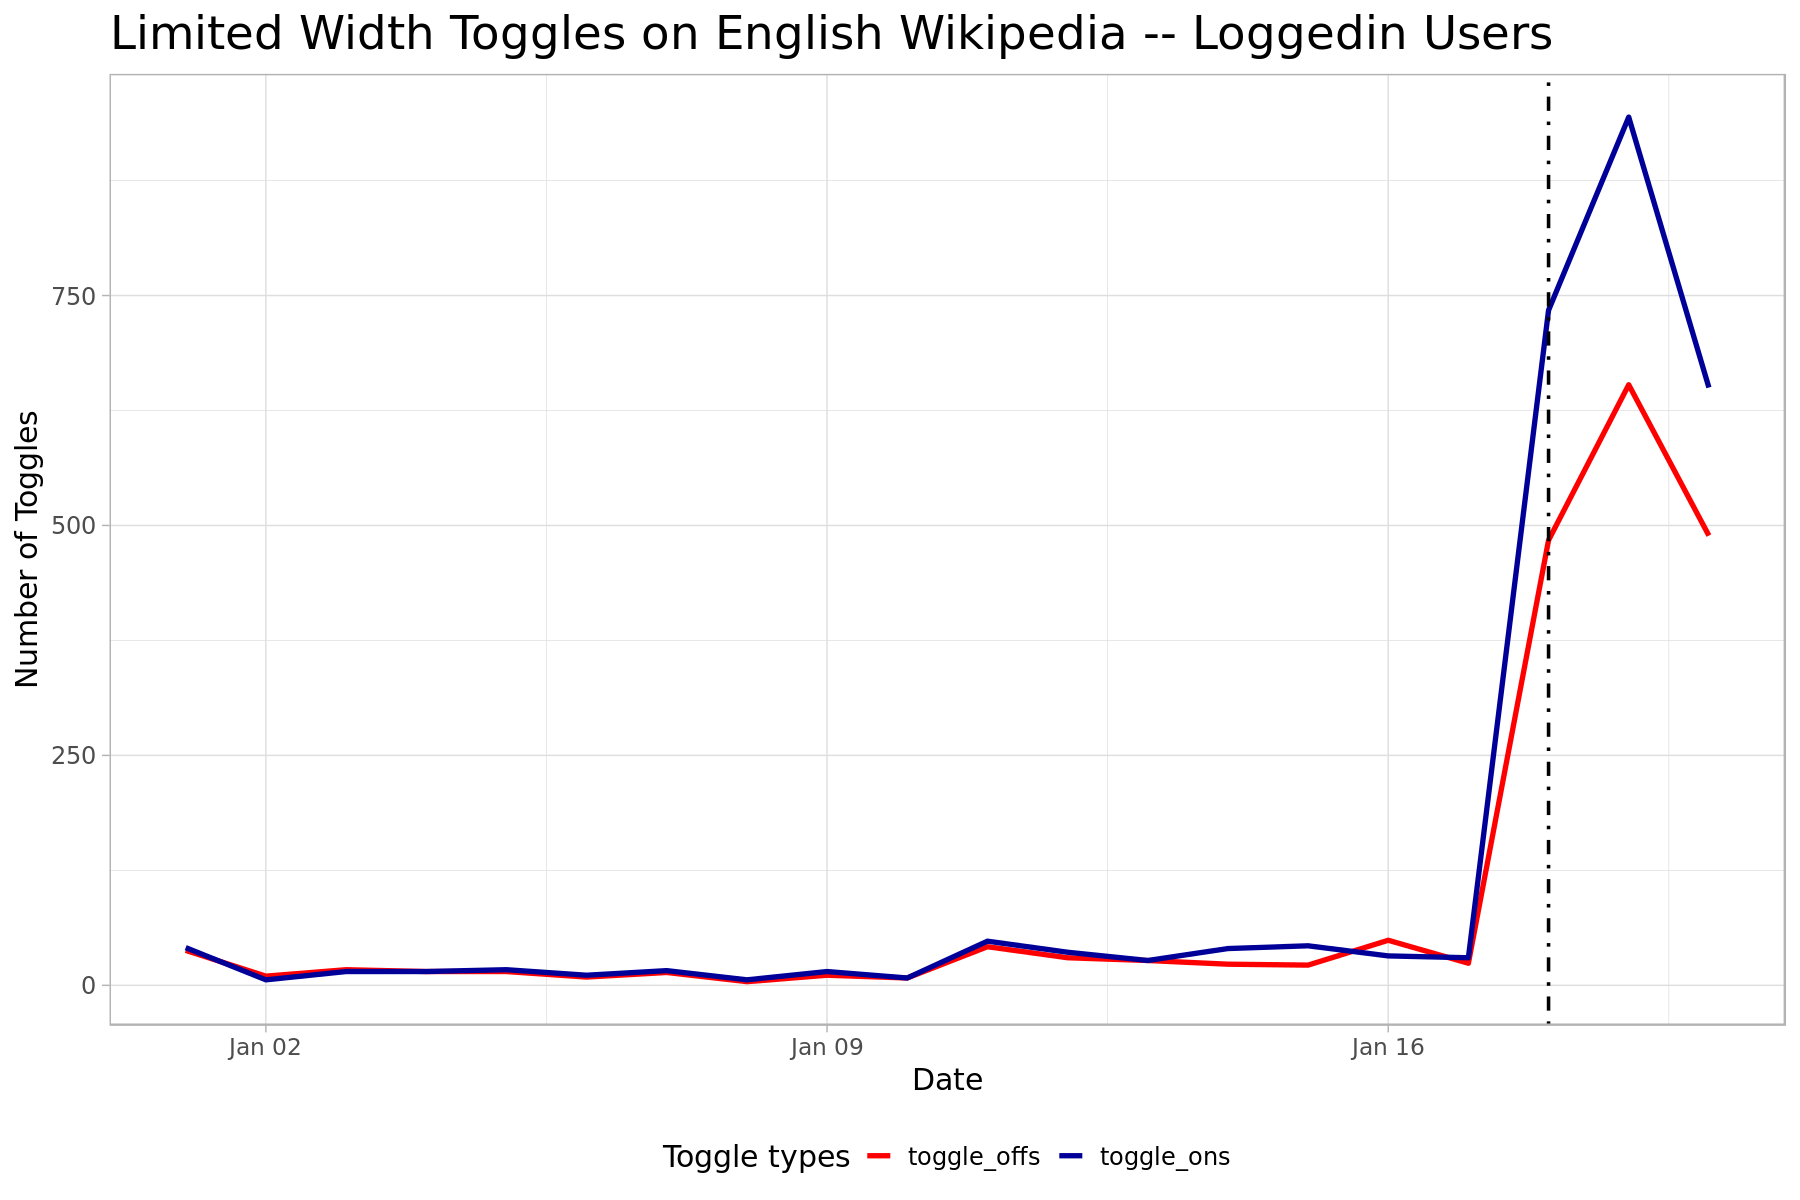

In [40]:
toggle_on_vs_off_login_g <- df_on_vs_off  %>%

   filter(isanon=='false') %>%
    # exclude the recent incompleted day
    slice(1:(n() - 2)) %>%
   ggplot(mapping=aes(x=event_date, y=events, color=types )) +
   geom_line( size = 1.5) +
   geom_vline(aes(xintercept = as.numeric(as.Date('2023-01-18'))), linetype="dotdash", color="black", size=1)+
   scale_color_manual(values= c("#FF0000", "#000099"), name = "Toggle types")  +
  labs(title = 'Limited Width Toggles on English Wikipedia -- Loggedin Users',
     x = 'Date',
     y = 'Number of Toggles') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
toggle_on_vs_off_login_g 

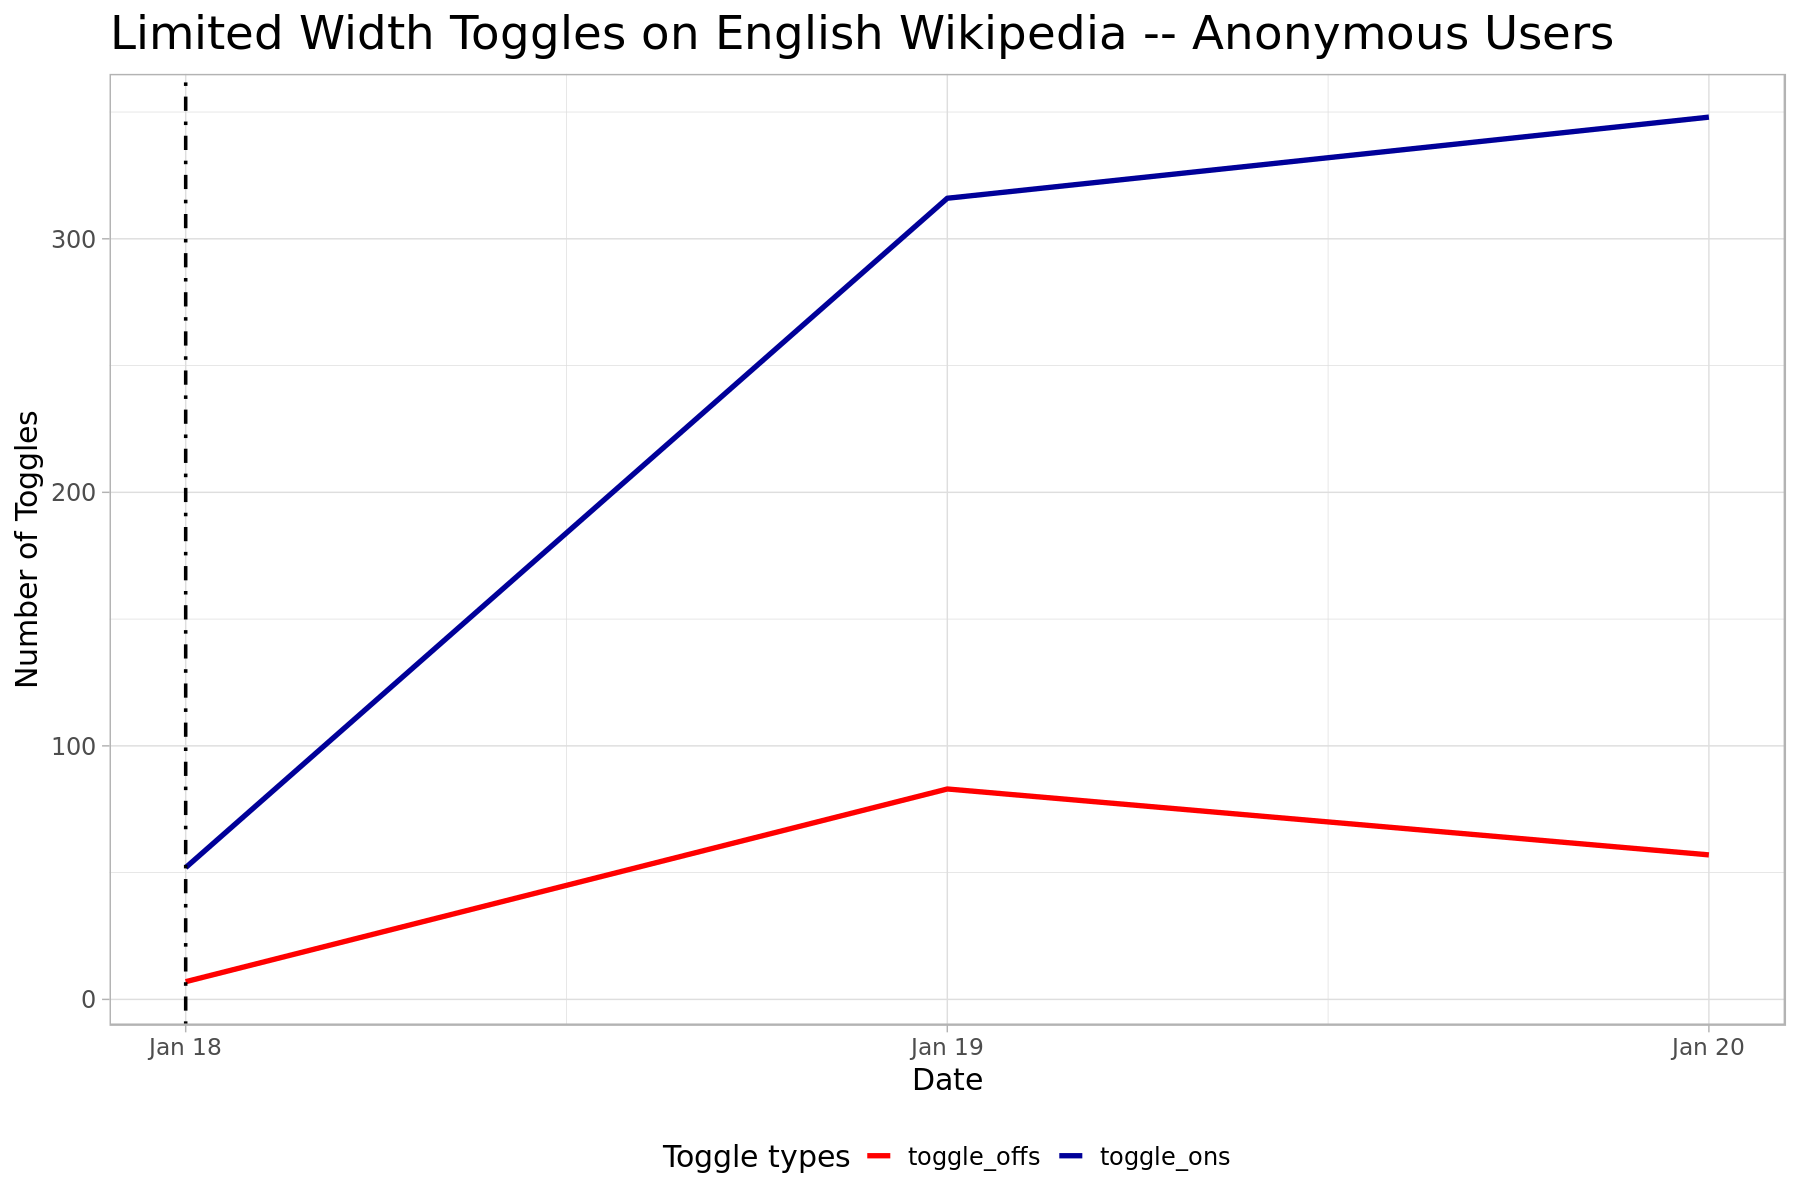

In [41]:
toggle_on_vs_off_anon_g <- df_on_vs_off  %>%
   filter(isanon=='true') %>%
   # exclude the recent incompleted day
    slice(1:(n() - 2)) %>%
   ggplot(mapping=aes(x=event_date, y=events, color=types )) +
   geom_line( size = 1.5) +
   geom_vline(aes(xintercept = as.numeric(as.Date('2023-01-18'))), linetype="dotdash", color="black", size=1)+
   scale_color_manual(values= c("#FF0000", "#000099"), name = "Toggle types")  +
  labs(title = 'Limited Width Toggles on English Wikipedia -- Anonymous Users',
     x = 'Date',
     y = 'Number of Toggles') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
toggle_on_vs_off_anon_g 

__Summary__ 

__Most of users chose to keep fixed width on, given:__ (Below summary need to adjust after engineer confirmed the instrumentation and its interperation)
- Number of unique toggled sessions is close to the number of toggled on sessions. It means most users chose to keep fixed width on after exploring the new feature.
- For both logged-in users and anonymous users, the number of clicks to toggle on limited width is higher than that to toggle off limited width.

__Many users are interested in trying the toggle feature after deployment.__
- For logged-in users, the session toggle rate surged to 0.5265% on 2023-01-18. Then it is gradually returning to the pre-deployment level. Similarly, the toggle on rate surged to 0.12% on 2023-01-18. It means many users are interested to try the toggle feature after the deployment.

__Logged-in users and anonymous users show similar trends.__
- For anonymous users, the session toggle rate and toggle on rate are similar to those of logged-in users. As we only have data for anonymous users for 3 days, we need more time to observe its long term trend.
